In [36]:
import gym
import gym_rlio

In [37]:
env = gym.make('rlio-v0')

In [38]:
env.load_data(
    stores=[4600],
    products=[
        616400, 564900, 582700, 720600, 1934800, 2011600
    ]
)

4600
Store file found!


<h3>Agent</h3>

In [39]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [40]:
tf.random.set_seed(73)
np.random.seed(73)

In [41]:
num_states = 8
num_actions = 2

upper_bound = 20
lower_bound = [0, 1] # ROL, OUL

# ROL < OUL


print("Size of State Space ->  {}".format(num_states))
print("Size of Action Space ->  {}".format(num_actions))

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  8
Size of Action Space ->  2
Max Value of Action ->  20
Min Value of Action ->  [0, 1]


<h4>Exploration noise</h4>

<h4>Buffer</h4>

In [42]:
# Buffer stores experiences, when the capacity is exceeded, it starts overriding past data

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

<h4>Actor + Critic</h4>

In [43]:
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(num_actions, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

<h4>Policy (take action)</h4>

In [44]:
def policy(state, train=True):
    sampled_actions = tf.squeeze(actor_model(state))
    # Adding noise to actions
    if train:
        sampled_actions = sampled_actions.numpy() + np.random.normal(loc=0.5, scale=1.0, size=sampled_actions.shape)
    else:
        sampled_actions = sampled_actions.numpy()

    # We make sure action is within bounds
    legal_actions = np.clip(sampled_actions, lower_bound, upper_bound)

    if num_actions == 1:
        return [np.squeeze(legal_actions)]
    else:
        return legal_actions

<h4>Initialize agent</h4>

In [50]:
# init actor
actor_model = get_actor()
critic_model = get_critic()

# init critic
target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_optimizer = tf.keras.optimizers.Adam(lr=0.0004)
actor_optimizer = tf.keras.optimizers.Adam(lr=0.0002)

total_episodes = 10
# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.005

buffer = Buffer(50000, 128) # capacity, batch_size

<h4>Environment Helpers</h4>

In [51]:
def convert_obs_to_policy_state(obs):
    #print(obs)
    keys = list(obs[4600].keys())
    #'date', 'stock', 'demand', 'sales', 'flag_promo', 'mply_qty', 'lead_time', 'batch_size'
    vals = [list(v.values())[:-1] for v in list(obs[4600].values())]
    # weekday, month, stock, demand, ....
    vals = [[v[0].weekday(), v[0].month, *v[1:]] for v in vals]
    return vals, keys

In [52]:
def convert_reward(rew):
    return list(rew[4600].values())

In [53]:
def convert_policies_to_env(p, keys):
    return {4600: dict(zip(keys, p.tolist()))}

<h4>Simulate</h4>

In [49]:
# 616400, 564900, 582700, 720600, 1934800, 2011600

In [55]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

for ep in range(total_episodes):
    prev_state, reward, done, _ = env.reset()
    episodic_reward = 0
    
    debug_reward = []
    debug_sales = []
    debug_actions = []
    debug_demand = []
    
    i = 0
    while True:
        prev_state_arr, keys = convert_obs_to_policy_state(prev_state)
        tf_prev_state = tf.convert_to_tensor(prev_state_arr)
        
        # debug info
        debug_sales.append(np.array(prev_state_arr)[:, 4].mean())
        debug_demand.append(np.array(prev_state_arr)[:, 3].mean())
        
        # get policy
        action = policy(tf_prev_state, train=True)
        
        # convert to environemnt norms # ROL + RUL
        env_action = np.ceil(action)
        
        # debug info
        debug_actions.append(env_action.mean(axis=0))
        
        # Recieve state and reward from environment.
        state, reward, done, _ = env.step(convert_policies_to_env(env_action, keys))
        #
        state_arr, keys = convert_obs_to_policy_state(state)
        
        for p_s, a, r, s in zip(prev_state_arr, action, convert_reward(reward), state_arr):
            buffer.record((p_s, a, r, s))
            episodic_reward += r
            
        # mean reward for all stores for a day
        debug_reward.append(np.mean(convert_reward(reward)))
        
        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        # End this episode when `done` is True
        if done:
            break

        prev_state = state
        
        i = i+1
        if i % 100 == 0:
            print('Debug {}, total reward: {}, avg sales: {}'.format(\
                    i, np.mean(debug_reward[-100:]), np.mean(debug_sales[-100:])))
        
    # Mean of this episode
    avg_ep_reward = np.mean(debug_reward)
    avg_ep_action = np.mean(debug_actions, axis=0)
    # Total of this episode
    ep_reward_list.append(episodic_reward)
    avg_reward_list.append(avg_ep_reward)
    
    print("Episode * {} * Avg Reward is ==> {} * Total Reward is ==> {} * Avg Action is ==> {}"\
          .format(ep, avg_ep_reward, episodic_reward, np.round(avg_ep_action, 2)))

Debug 100, total reward: 0.7102222222222223, avg sales: 1.582
Debug 200, total reward: 0.9781481481481482, avg sales: 1.6449999999999998
Debug 300, total reward: 0.9888888888888892, avg sales: 1.6833333333333333
Debug 400, total reward: 0.6848148148148151, avg sales: 1.5866666666666662
Debug 500, total reward: 0.030000000000000235, avg sales: 0.9983333333333334
Debug 600, total reward: 0.3137037037037039, avg sales: 1.0299999999999998
Debug 700, total reward: 0.6642592592592593, avg sales: 1.445
Debug 800, total reward: 0.48629629629629656, avg sales: 1.4199999999999997
Debug 900, total reward: 0.48092592592592615, avg sales: 1.18
Debug 1000, total reward: 0.5270370370370372, avg sales: 1.2733333333333334
Debug 1100, total reward: 0.6325925925925928, avg sales: 1.3416666666666666
Debug 1200, total reward: 0.44314814814814846, avg sales: 1.143333333333333
Debug 1300, total reward: 0.237927737196743, avg sales: 1.0950000000000002
Debug 1400, total reward: -0.14698005698005678, avg sales:

Debug 300, total reward: 1.0981481481481483, avg sales: 1.605
Debug 400, total reward: 0.9255555555555556, avg sales: 1.38
Debug 500, total reward: 0.2044444444444446, avg sales: 1.0183333333333335
Debug 600, total reward: 0.04481481481481505, avg sales: 1.015
Debug 700, total reward: 0.8305555555555556, avg sales: 1.4
Debug 800, total reward: 0.5383333333333336, avg sales: 1.4016666666666666
Debug 900, total reward: 0.08685185185185215, avg sales: 1.2433333333333332
Debug 1000, total reward: 0.2929629629629632, avg sales: 1.2466666666666666
Debug 1100, total reward: 0.7196296296296296, avg sales: 1.3666666666666665
Debug 1200, total reward: 0.47000000000000014, avg sales: 1.1633333333333333
Debug 1300, total reward: 0.4387493543926293, avg sales: 1.1266666666666667
Debug 1400, total reward: 0.45776353276353293, avg sales: 1.1600000000000001
Episode * 7 * Avg Reward is ==> 0.5024378173988312 * Total Reward is ==> 4343.62568101159 * Avg Action is ==> [5.63464052 8.195845  ]
Debug 100, t

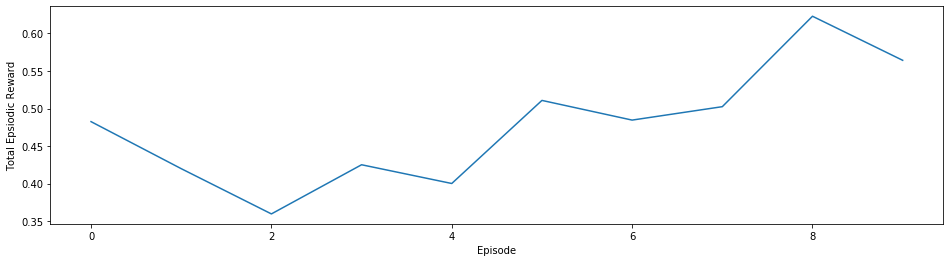

In [57]:
import matplotlib.pyplot as plt
# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(avg_reward_list);
plt.xlabel("Episode")
plt.ylabel("Total Epsiodic Reward")
plt.show()

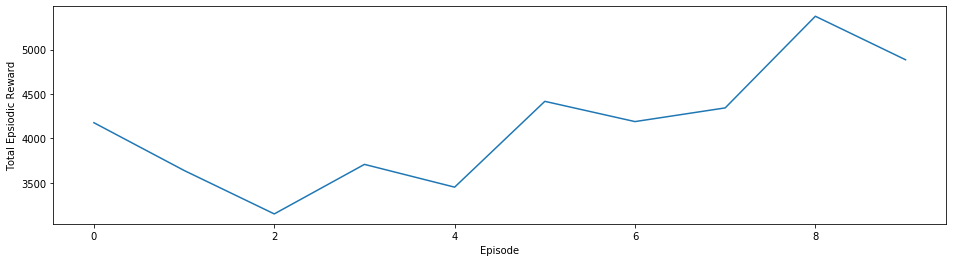

In [58]:
import matplotlib.pyplot as plt
# Plotting graph
# Episodes versus Avg. Rewards
plt.figure(figsize=(16,4));
plt.plot(ep_reward_list);
plt.xlabel("Episode")
plt.ylabel("Total Epsiodic Reward")
plt.show()

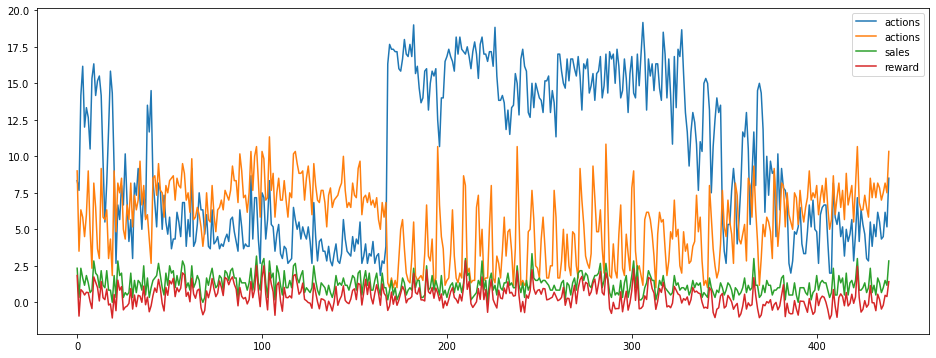

In [59]:
plt.figure(figsize=(16,6));
plt.plot(debug_actions[-500:-60], label='actions');
plt.plot(debug_sales[-500:-60], label='sales');
plt.plot(debug_reward[-500:-60], label='reward');
plt.legend();

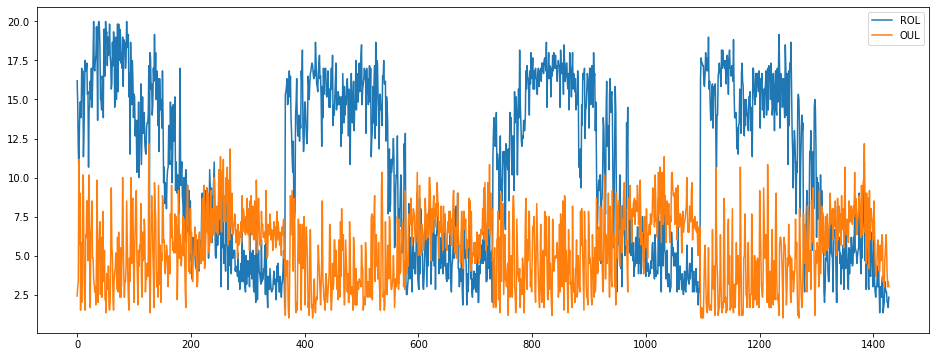

In [68]:
plt.figure(figsize=(16,6));
plt.plot(np.array(debug_actions)[:, 0], label='ROL');
plt.plot(np.array(debug_actions)[:, 1], label='OUL');
plt.legend();

In [39]:
actor_model.save('actor_model_v3.h5')

<h2>Baseline</h2>

In [34]:
debug_reward = []

prev_state, reward, done, _ = env.reset()

i = 0
while True:
    prev_state_arr, keys = convert_obs_to_policy_state(prev_state)
    
    env_action = np.array(len(prev_state_arr) * [[5, 5]])
    state, reward, done, _ = env.step(convert_policies_to_env(env_action, keys))
    
    debug_reward.append(np.sum(convert_reward(reward)))

    # End this episode when `done` is True
    if done:
        break
        
    prev_state = state
    i = i+1
    
    if i % 100 == 0:
        print(i, np.mean(debug_reward[-100:]))
        
print("Total Reward is ==> {}".format(np.sum(debug_reward)))

100 441.8888888888889
200 505.11111111111114
300 545.6666666666667
400 552.8888888888888
500 217.44444444444449
600 122.66666666666671
700 471.7777777777778
800 401.3333333333333
900 263.66666666666674
1000 289.2222222222223
1100 404.5555555555556
1200 308.0
1300 304.6770130454341
1400 383.6495726495728


<h2>Validation</h2>

In [66]:
prev_state, reward, done, _ = env.reset()
episodic_reward = 0

debug_reward = []

i = 0
while True:
    prev_state_arr, keys = convert_obs_to_policy_state(prev_state)
    tf_prev_state = tf.convert_to_tensor(prev_state_arr)

    action = policy(tf_prev_state, False)
    env_action = np.ceil(action)

    # Recieve state and reward from environment.
    state, reward, done, _ = env.step(convert_policies_to_env(env_action, keys))
    #
    state_arr, keys = convert_obs_to_policy_state(state)

    debug_reward.append(np.mean(convert_reward(reward)))

    # End this episode when `done` is True
    if done:
        break

    prev_state = state
    i = i+1

    if i % 100 == 0:
        env.render()
        #print(np.mean(debug_reward[-100:]))

10.04.2016 (Day 101 of 1429)
-------------------------------------------------------------------------------------------------------
Store      | SKU        | Current Stock | Next Order | Last Policy | Last Reward | Sum Reward          
-------------------------------------------------------------------------------------------------------
      4600 |     564900 | 3             |          0 | [18.0, 1.0] |        0.56 |             -3084.88
      4600 |     582700 | 1             |          0 | [2.0, 2.0]  |       -0.33 |             -3579.02
      4600 |     616400 | 9             |          0 | [20.0, 1.0] |        1.11 |             -5799.33
      4600 |     720600 | 7             |          0 | [20.0, 1.0] |       -0.78 |             15887.39
      4600 |    1934800 | 0             |          7 | [20.0, 10.0] |        2.67 |             25694.37
      4600 |    2011600 | 5             |          0 | [11.0, 6.0] |        2.00 |             13268.20

19.07.2016 (Day 201 of 1429)
----

KeyboardInterrupt: 